# Skin Cancer Image Processing and Baseline Model

In [13]:
# Import Relevant Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras import models
from keras import layers
np.random.seed(123)

In [35]:
# Defining a results visualization function
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [14]:
!ls ../data

Additional_malignant
ISIC_2019_512x512
ISIC_2019_512x512.csv
ISIC_2019_Training_GroundTruth.csv
ISIC_2019_Training_Input
ISIC_2019_Training_Metadata.csv
ISIC_2020_Training_GroundTruth.csv
ISIC_2020_Training_JPEG
ISIC_FINAL_DATASET.csv
add_train_malig_2.csv


In [15]:
# Reading in the final dataset from Data_Exploration.ipynb
df = pd.read_csv('../data/ISIC_FINAL_DATASET.csv')
df

,Unnamed: 0,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,path,lesion_id,width,height,source,ext,tfrecord
0,0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,../data/ISIC_2020_Training_JPEG/ISIC_2637011.jpg,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,../data/ISIC_2020_Training_JPEG/ISIC_0015719.jpg,NaN,NaN,NaN,NaN,NaN,NaN
2,2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,../data/ISIC_2020_Training_JPEG/ISIC_0052212.jpg,NaN,NaN,NaN,NaN,NaN,NaN
3,3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,../data/ISIC_2020_Training_JPEG/ISIC_0068279.jpg,NaN,NaN,NaN,NaN,NaN,NaN
4,4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,../data/ISIC_2020_Training_JPEG/ISIC_0074268.jpg,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58779,58779,ISIC_0024302,-1,female,25.0,NaN,melanoma,malignant,1,../data/Additional_malignant/ISIC_0024302.jpg,NaN,3008.0,2000.0,2018 JID Editorial Images,jpg,29.0
58780,58780,ISIC_0024303,-1,male,60.0,NaN,squamous cell carcinoma,malignant,1,../data/Additional_malignant/ISIC_0024303.jpg,NaN,3008.0,2000.0,2018 JID Editorial Images,jpg,29.0
58781,58781,ISIC_0024304,-1,male,70.0,NaN,squamous cell carcinoma,malignant,1,../data/Additional_malignant/ISIC_0024304.jpg,NaN,3008.0,2000.0,2018 JID Editorial Images,jpg,29.0
58782,58782,ISIC_0024305,-1,male,85.0,NaN,squamous cell carcinoma,malignant,1,../data/Additional_malignant/ISIC_0024305.jpg,NaN,4288.0,2848.0,2018 JID Editorial Images,jpg,29.0


In [16]:
# Define X and y 
X = df[['image_name', 'path', 'sex', 'age_approx', 'anatom_site_general_challenge']]
y = df['benign_malignant']

In [17]:
X

,image_name,path,sex,age_approx,anatom_site_general_challenge
0,ISIC_2637011,../data/ISIC_2020_Training_JPEG/ISIC_2637011.jpg,male,45.0,head/neck
1,ISIC_0015719,../data/ISIC_2020_Training_JPEG/ISIC_0015719.jpg,female,45.0,upper extremity
2,ISIC_0052212,../data/ISIC_2020_Training_JPEG/ISIC_0052212.jpg,female,50.0,lower extremity
3,ISIC_0068279,../data/ISIC_2020_Training_JPEG/ISIC_0068279.jpg,female,45.0,head/neck
4,ISIC_0074268,../data/ISIC_2020_Training_JPEG/ISIC_0074268.jpg,female,55.0,upper extremity
...,...,...,...,...,...
58779,ISIC_0024302,../data/Additional_malignant/ISIC_0024302.jpg,female,25.0,NaN
58780,ISIC_0024303,../data/Additional_malignant/ISIC_0024303.jpg,male,60.0,NaN
58781,ISIC_0024304,../data/Additional_malignant/ISIC_0024304.jpg,male,70.0,NaN
58782,ISIC_0024305,../data/Additional_malignant/ISIC_0024305.jpg,male,85.0,NaN


In [18]:
# Train - Holdout Set Split
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [19]:
# Regular Train - Test Split
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [20]:
# Train dataframe
df_tr = pd.concat([X_tr, y_tr], axis=1)
print(f'Train dataset: \n {df_tr.benign_malignant.value_counts()}')
df_tr

Train dataset: 
 benign       35386
malignant     6938
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
9434,ISIC_2925481,../data/ISIC_2020_Training_JPEG/ISIC_2925481.jpg,female,50.0,lower extremity,benign
22571,ISIC_6847618,../data/ISIC_2020_Training_JPEG/ISIC_6847618.jpg,female,50.0,torso,benign
20461,ISIC_6225557,../data/ISIC_2020_Training_JPEG/ISIC_6225557.jpg,female,55.0,torso,benign
18738,ISIC_5689428,../data/ISIC_2020_Training_JPEG/ISIC_5689428.jpg,female,45.0,lower extremity,benign
26607,ISIC_8065339,../data/ISIC_2020_Training_JPEG/ISIC_8065339.jpg,female,50.0,torso,benign
...,...,...,...,...,...,...
34,ISIC_0086632,../data/ISIC_2020_Training_JPEG/ISIC_0086632.jpg,male,40.0,torso,benign
49365,ISIC_0059066,../data/ISIC_2019_Training_Input/ISIC_0059066.jpg,male,55.0,anterior torso,malignant
27016,ISIC_8185167,../data/ISIC_2020_Training_JPEG/ISIC_8185167.jpg,female,65.0,palms/soles,benign
45712,ISIC_0034129,../data/ISIC_2019_Training_Input/ISIC_0034129.jpg,male,60.0,NaN,benign


In [21]:
# Test dataframe
df_te = pd.concat([X_te, y_te], axis=1)
print(f'Test dataset: \n {df_te.benign_malignant.value_counts()}')
df_te

Test dataset: 
 benign       8846
malignant    1735
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
3750,ISIC_1233016,../data/ISIC_2020_Training_JPEG/ISIC_1233016.jpg,female,45.0,torso,benign
48547,ISIC_0057785,../data/ISIC_2019_Training_Input/ISIC_0057785.jpg,male,75.0,upper extremity,benign
10510,ISIC_3249783,../data/ISIC_2020_Training_JPEG/ISIC_3249783.jpg,male,35.0,upper extremity,benign
11115,ISIC_3427677,../data/ISIC_2020_Training_JPEG/ISIC_3427677.jpg,female,45.0,upper extremity,benign
29627,ISIC_8962773,../data/ISIC_2020_Training_JPEG/ISIC_8962773.jpg,male,50.0,upper extremity,benign
...,...,...,...,...,...,...
16877,ISIC_5162699,../data/ISIC_2020_Training_JPEG/ISIC_5162699.jpg,female,50.0,torso,benign
12251,ISIC_3768804,../data/ISIC_2020_Training_JPEG/ISIC_3768804.jpg,female,45.0,lower extremity,benign
43136,ISIC_0031507,../data/ISIC_2019_Training_Input/ISIC_0031507.jpg,male,65.0,NaN,benign
15427,ISIC_4722884,../data/ISIC_2020_Training_JPEG/ISIC_4722884.jpg,male,55.0,torso,benign


In [22]:
# Hold-out dataframe:
df_hold = pd.concat([X_hold, y_hold], axis=1)
print(f'Hold-out dataset: \n {df_hold.benign_malignant.value_counts()}')
df_hold

Hold-out dataset: 
 benign       4915
malignant     964
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
4856,ISIC_1560455,../data/ISIC_2020_Training_JPEG/ISIC_1560455.jpg,female,50.0,lower extremity,benign
26256,ISIC_7969673,../data/ISIC_2020_Training_JPEG/ISIC_7969673.jpg,female,45.0,lower extremity,benign
7187,ISIC_2248231,../data/ISIC_2020_Training_JPEG/ISIC_2248231.jpg,male,55.0,torso,benign
54145,ISIC_0066776,../data/ISIC_2019_Training_Input/ISIC_0066776.jpg,female,85.0,lower extremity,malignant
10518,ISIC_3251421,../data/ISIC_2020_Training_JPEG/ISIC_3251421.jpg,male,55.0,upper extremity,benign
...,...,...,...,...,...,...
50860,ISIC_0061478,../data/ISIC_2019_Training_Input/ISIC_0061478.jpg,female,10.0,lower extremity,benign
47994,ISIC_0056875,../data/ISIC_2019_Training_Input/ISIC_0056875.jpg,male,75.0,head/neck,malignant
21759,ISIC_6588881,../data/ISIC_2020_Training_JPEG/ISIC_6588881.jpg,male,55.0,torso,benign
30088,ISIC_9091415,../data/ISIC_2020_Training_JPEG/ISIC_9091415.jpg,male,60.0,lower extremity,benign


## Step 1: Baseline Model 

In [11]:
# Instantiating a generator object and normalizing the RGB values, and creating the generator:

# Creating the generator for the training data
train_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_tr,
                                                                             x_col='path',
                                                                             y_col='benign_malignant',
                                                                             # Re-sizing images to 256x256
                                                                             target_size=(256, 256),
                                                                             batch_size= int(len(df_tr)/5))

# Creating the generator for the testing data
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_te,
                                                                             x_col='path',
                                                                             y_col='benign_malignant',
                                                                             # Re-sizing images to 256x256
                                                                             target_size=(256, 256), 
                                                                             batch_size= int(len(df_te)/5))
# Setting aside a hold-out set
hold_generator =  ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_hold,
                                                                             x_col='path',
                                                                             y_col='benign_malignant',
                                                                             # Re-sizing images to 256x256
                                                                             target_size=(256, 256),
                                                                             batch_size= int(len(df_hold)/5))


Found 42324 validated image filenames belonging to 2 classes.
Found 10581 validated image filenames belonging to 2 classes.
Found 5879 validated image filenames belonging to 2 classes.


In [12]:
# This cell took ~20 min to run!
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
hold_images, hold_labels = next(hold_generator)

In [13]:
# Check classes
print(f"Train data set classes, {train_generator.class_indices}")
print(f"Test data set classes, {test_generator.class_indices}")
print(f"Hold-out data set classes, {hold_generator.class_indices}")

Train data set classes, {'benign': 0, 'malignant': 1}
Test data set classes, {'benign': 0, 'malignant': 1}
Hold-out data set classes, {'benign': 0, 'malignant': 1}


In [14]:
# Explore dataset again
m_train = train_images.shape[0]
m_test = test_images.shape[0]
m_hold = hold_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_hold))

print ("train_images shape: " + str(train_images.shape))   # batch_size=int(len(df_tr)/5) --> 42324/5 = 8464
print ("train_labels shape: " + str(train_labels.shape))

print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

print ("hold_images shape: " + str(hold_images.shape))
print ("hold_labels shape: " + str(hold_labels.shape))

Number of training samples: 8464
Number of testing samples: 2116
Number of validation samples: 1175
train_images shape: (8464, 256, 256, 3)
train_labels shape: (8464, 2)
test_images shape: (2116, 256, 256, 3)
test_labels shape: (2116, 2)
hold_images shape: (1175, 256, 256, 3)
hold_labels shape: (1175, 2)


In [15]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
hold_img = hold_images.reshape(hold_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(hold_img.shape)

(8464, 196608)
(2116, 196608)
(1175, 196608)


In [16]:
train_y = np.reshape(train_labels[:, 0], (8464, 1))
test_y = np.reshape(test_labels[:, 0], (2116, 1))
hold_y = np.reshape(hold_labels[:, 0], (1175, 1))

In [19]:
# Fitting a Neural Network Model
model = models.Sequential()

# Adding layers
model.add(layers.Dense(20, activation='relu', input_shape=(196608,))) # input layer
model.add(layers.Dense(7, activation='relu')) # hidden layer
model.add(layers.Dense(5, activation='relu')) # hidden layer
model.add(layers.Dense(1, activation='sigmoid')) # output layer

In [20]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,  # mini batches of 32 units!
                    validation_data=(test_img, test_y))

Epoch 1/50
265/265 [==============================] - 7s 25ms/step - loss: 0.4186 - accuracy: 0.8318 - val_loss: 0.3576 - val_accuracy: 0.8511
Epoch 2/50
265/265 [==============================] - 6s 22ms/step - loss: 0.3850 - accuracy: 0.8375 - val_loss: 0.3377 - val_accuracy: 0.8563
Epoch 3/50
265/265 [==============================] - 6s 22ms/step - loss: 0.3758 - accuracy: 0.8358 - val_loss: 0.3326 - val_accuracy: 0.8615
Epoch 4/50
265/265 [==============================] - 6s 21ms/step - loss: 0.3683 - accuracy: 0.8367 - val_loss: 0.3313 - val_accuracy: 0.8639
Epoch 5/50
265/265 [==============================] - 6s 22ms/step - loss: 0.3642 - accuracy: 0.8367 - val_loss: 0.3410 - val_accuracy: 0.8639
Epoch 6/50
265/265 [==============================] - 6s 22ms/step - loss: 0.3626 - accuracy: 0.8379 - val_loss: 0.3372 - val_accuracy: 0.8582
Epoch 7/50
265/265 [==============================] - 6s 24ms/step - loss: 0.3567 - accuracy: 0.8361 - val_loss: 0.3334 - val_accuracy: 0.8686

In [21]:
results_train = model.evaluate(train_img, train_y)

265/265 [==============================] - 2s 9ms/step - loss: 0.3103 - accuracy: 0.8570


In [22]:
results_test = model.evaluate(test_img, test_y)

67/67 [==============================] - 1s 8ms/step - loss: 0.3110 - accuracy: 0.8582


In [23]:
results_train
# training accuracy 85%

[0.3103067874908447, 0.857041597366333]

In [24]:
results_test
# test set accuracy 85%

[0.3110007345676422, 0.8582230806350708]

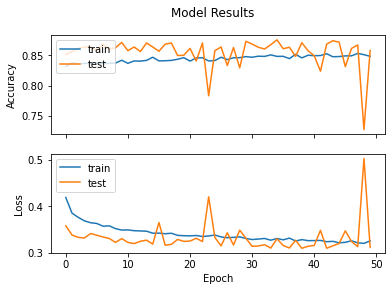

In [26]:
# Visualize the trainong results:
visualize_training_results(history)

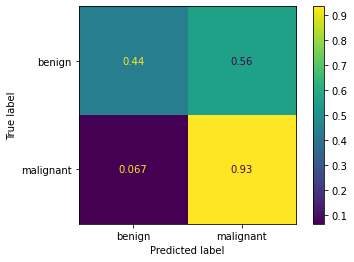

In [38]:
# confusion matrix for test set:
predictions = model.predict_classes(test_img)
cm = confusion_matrix(test_y, predictions, labels=[0, 1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
disp.plot()
plt.show()

- We have 85% accuracy score for both train and test set. 
- I will do more preprocessing to images to see if will help to improve accuracy score of both train and test set.

## Step 2: Modeling with More Image Preprocessing 

In [51]:
# Instantiating a generator object and normalizing the RGB values, and creating the generator:

# Creating the generator for the training data
train_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True).flow_from_dataframe(df_tr,
                                                                             x_col='path',
                                                                             y_col='benign_malignant',
                                                                             # Re-sizing images to 256x256
                                                                             target_size=(256, 256),
                                                                             batch_size= int(len(df_tr)/5))

# Creating the generator for the testing data
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_te,
                                                                             x_col='path',
                                                                             y_col='benign_malignant',
                                                                             # Re-sizing images to 256x256
                                                                             target_size=(256, 256), 
                                                                             batch_size= int(len(df_te)/5))
# Setting aside a hold-out set
hold_generator =  ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_hold,
                                                                             x_col='path',
                                                                             y_col='benign_malignant',
                                                                             # Re-sizing images to 256x256
                                                                             target_size=(256, 256),
                                                                             batch_size= int(len(df_hold)/5))

Found 42324 validated image filenames belonging to 2 classes.
Found 10581 validated image filenames belonging to 2 classes.
Found 5879 validated image filenames belonging to 2 classes.


In [52]:
# This cell took ~20 min to run!
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
hold_images, hold_labels = next(hold_generator)

In [53]:
# Check classes
print(f"Train data set classes, {train_generator.class_indices}")
print(f"Test data set classes, {test_generator.class_indices}")
print(f"Hold-out data set classes, {hold_generator.class_indices}")

Train data set classes, {'benign': 0, 'malignant': 1}
Test data set classes, {'benign': 0, 'malignant': 1}
Hold-out data set classes, {'benign': 0, 'malignant': 1}


In [54]:
# Explore dataset again
m_train = train_images.shape[0]
m_test = test_images.shape[0]
m_hold = hold_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_hold))

print ("train_images shape: " + str(train_images.shape))   # batch_size=int(len(df_tr)/5) --> 42324/5 = 8464
print ("train_labels shape: " + str(train_labels.shape))

print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

print ("hold_images shape: " + str(hold_images.shape))
print ("hold_labels shape: " + str(hold_labels.shape))

Number of training samples: 8464
Number of testing samples: 2116
Number of validation samples: 1175
train_images shape: (8464, 256, 256, 3)
train_labels shape: (8464, 2)
test_images shape: (2116, 256, 256, 3)
test_labels shape: (2116, 2)
hold_images shape: (1175, 256, 256, 3)
hold_labels shape: (1175, 2)


In [55]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
hold_img = hold_images.reshape(hold_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(hold_img.shape)

(8464, 196608)
(2116, 196608)
(1175, 196608)


In [56]:
train_y = np.reshape(train_labels[:, 0], (8464, 1))
test_y = np.reshape(test_labels[:, 0], (2116, 1))
hold_y = np.reshape(hold_labels[:, 0], (1175, 1))

In [57]:
# Fitting a Neural Network Model
model2 = models.Sequential()

# Adding layers
model2.add(layers.Dense(20, activation='relu', input_shape=(196608,))) # input layer
model2.add(layers.Dense(7, activation='relu')) # hidden layer
model2.add(layers.Dense(5, activation='relu')) # hidden layer
model2.add(layers.Dense(1, activation='sigmoid')) # output layer

In [58]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,  # mini batches of 32 units!
                    validation_data=(test_img, test_y))

Epoch 1/50
265/265 [==============================] - 6s 23ms/step - loss: 0.7059 - accuracy: 0.8287 - val_loss: 0.3896 - val_accuracy: 0.8483
Epoch 2/50
265/265 [==============================] - 6s 21ms/step - loss: 0.4172 - accuracy: 0.8331 - val_loss: 0.3896 - val_accuracy: 0.8507
Epoch 3/50
265/265 [==============================] - 6s 21ms/step - loss: 0.4092 - accuracy: 0.8352 - val_loss: 0.3668 - val_accuracy: 0.8526
Epoch 4/50
265/265 [==============================] - 6s 21ms/step - loss: 0.3972 - accuracy: 0.8367 - val_loss: 0.3599 - val_accuracy: 0.8540
Epoch 5/50
265/265 [==============================] - 6s 21ms/step - loss: 0.3931 - accuracy: 0.8352 - val_loss: 0.3504 - val_accuracy: 0.8540
Epoch 6/50
265/265 [==============================] - 6s 23ms/step - loss: 0.3864 - accuracy: 0.8372 - val_loss: 0.3584 - val_accuracy: 0.8554
Epoch 7/50
265/265 [==============================] - 6s 24ms/step - loss: 0.3851 - accuracy: 0.8380 - val_loss: 0.3504 - val_accuracy: 0.8559

In [59]:
results_train = model2.evaluate(train_img, train_y)

265/265 [==============================] - 2s 9ms/step - loss: 0.4011 - accuracy: 0.8255


In [60]:
results_test = model2.evaluate(test_img, test_y)

67/67 [==============================] - 1s 9ms/step - loss: 0.3932 - accuracy: 0.8133


In [65]:
results_train

[0.4010556638240814, 0.8254961967468262]

In [66]:
results_test

[0.393200159072876, 0.8133270144462585]

- Accuracy is 82% for train set and 81% for test set!

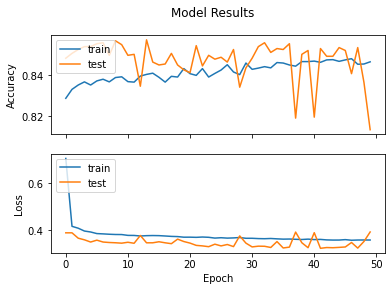

In [61]:
# Visualize the trainong results:
visualize_training_results(history2)

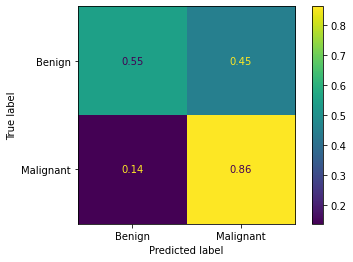

In [62]:
# confusion matrix for test set:
predictions = model2.predict_classes(test_img)
cm = confusion_matrix(test_y, predictions, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot()
plt.show()

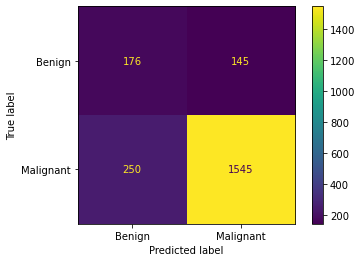

In [67]:
# confusion matrix for test set:
predictions = model2.predict_classes(test_img)
cm = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot()
plt.show()

In [63]:
pd.DataFrame(test_y).value_counts()

1.0    1795
0.0     321
dtype: int64

In [64]:
pd.DataFrame(predictions).value_counts()

1    1690
0     426
dtype: int64